# Task 2: User Engagement Analysis

Here the analysis focus on getting insights on the engagement of the customers by focusing on network metrics.

Task 2.1 
- Aggregate the above metrics per customer id (MSISDN) and report the top 10 customers per engagement metric 
- Normalize each engagement metric and run a k-means (k=3) to classify customers in three groups of engagement. 
- Compute the minimum, maximum, average & total non-normalized metrics for each cluster. Interpret your results visually with accompanying text explaining your findings.
- Aggregate user total traffic per application and derive the top 10 most engaged users per application
- Plot the top 3 most used applications using appropriate charts.  
- Using k-means clustering algorithm, group users in k engagement clusters based on the engagement metrics: 
    - What is the optimized value of k (use elbow method for this)?  
    - Interpret findings. 



In [1]:
import os
import sys

# path of the module files
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from utils import *
from load_db import load_data_from_postgres

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Define your SQL query
query = "SELECT * FROM xdr_data"  # Replace with your actual table name

# Load data from PostgreSQL
df = load_data_from_postgres(query)

# Display the first few rows of the dataframe
if df is not None:
    print("Successfully loaded the data")
else:
    print("Failed to load data.")


Successfully loaded the data


In [3]:
# describing the dataframe
print(df.shape)
df.head(3)

(150001, 55)


,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,1.311448e+19,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,1.311448e+19,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0


In [4]:
# Extracting main features for the analysis
main_columns = df[['MSISDN/Number','Dur. (ms)','Social Media DL (Bytes)','Social Media UL (Bytes)','Youtube DL (Bytes)','Youtube UL (Bytes)','Netflix DL (Bytes)','Netflix UL (Bytes)','Google DL (Bytes)','Google UL (Bytes)','Email DL (Bytes)','Email UL (Bytes)','Gaming DL (Bytes)','Gaming UL (Bytes)','Other DL (Bytes)','Other UL (Bytes)','Total UL (Bytes)','Total DL (Bytes)']].copy()
main_columns['number_of_session'] = 1   # to get the number of sessions of each users

main_columns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150001 entries, 0 to 150000
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   MSISDN/Number            148935 non-null  float64
 1   Dur. (ms)                150000 non-null  float64
 2   Social Media DL (Bytes)  150001 non-null  float64
 3   Social Media UL (Bytes)  150001 non-null  float64
 4   Youtube DL (Bytes)       150001 non-null  float64
 5   Youtube UL (Bytes)       150001 non-null  float64
 6   Netflix DL (Bytes)       150001 non-null  float64
 7   Netflix UL (Bytes)       150001 non-null  float64
 8   Google DL (Bytes)        150001 non-null  float64
 9   Google UL (Bytes)        150001 non-null  float64
 10  Email DL (Bytes)         150001 non-null  float64
 11  Email UL (Bytes)         150001 non-null  float64
 12  Gaming DL (Bytes)        150001 non-null  float64
 13  Gaming UL (Bytes)        150001 non-null  float64
 14  Othe

In [5]:
# aggregate the dataframe per users
main_columns['MSISDN/Number'] = main_columns['MSISDN/Number'].astype(str)    # to see if it aggregate on distinct customers properly

# adding the total volume column and droping value length to prepare for the aggregated dataframe
main_columns['Total Volume'] =  main_columns['Total UL (Bytes)'] + main_columns['Total DL (Bytes)'] 

# dataframe for user behavior
user_behavior = main_columns.groupby('MSISDN/Number').sum().reset_index()
user_behavior.head()

,MSISDN/Number,Dur. (ms),Social Media DL (Bytes),Social Media UL (Bytes),Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Google DL (Bytes),Google UL (Bytes),Email DL (Bytes),Email UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes),number_of_session,Total Volume
0,3197020876596.0,877385.0,668596.0,46628.0,9839889.0,2120016.0,10340908.0,16251392.0,8572779.0,1865881.0,842279.0,678492.0,164563605.0,13485133.0,467678100.0,2848373.0,37295915.0,194828056.0,1,232123971.0
1,33601001722.0,116720.0,2206504.0,25631.0,14900201.0,6724347.0,10265105.0,16915876.0,3337123.0,1051882.0,837400.0,493962.0,811091133.0,1367528.0,377096990.0,9473882.0,36053108.0,842637466.0,1,878690574.0
2,33601001754.0,181230.0,2598548.0,62017.0,5324251.0,7107972.0,770569.0,10451194.0,4197697.0,1137166.0,2828821.0,478960.0,105035298.0,14714780.0,279557701.0,2152370.0,36104459.0,120755184.0,1,156859643.0
3,33601002511.0,134969.0,3148004.0,47619.0,2137272.0,19196298.0,16525919.0,2827981.0,3343483.0,99643.0,2436500.0,768880.0,529068485.0,9759228.0,495086501.0,6607171.0,39306820.0,556659663.0,1,595966483.0
4,33601007832.0,49878.0,251469.0,28825.0,4393123.0,2584198.0,1157362.0,784730.0,5937765.0,3740728.0,2178618.0,106052.0,388074835.0,3051292.0,25248001.0,10031701.0,20327526.0,401993172.0,1,422320698.0


In [6]:
# data cleaning and adding of new columns performed on task 1
# segement customers into deciles
user_behavior['decile_class'] = pd.qcut(user_behavior['Dur. (ms)'], 10, labels = False) + 1

# duration second to mintues
user_behavior['Dur. (min)'] = user_behavior['Dur. (ms)'].apply(lambda x: ms_to_mintue(x))

# fixing outliers twice
# fix outliers 
numerical_columns = user_behavior.select_dtypes(include=np.number).columns

for i in range(2):
    for num_col in numerical_columns:
        user_behavior[num_col] = fix_outlier(user_behavior,num_col)

# dataframe with only the engagement metrics 
user_engagement = user_behavior[['MSISDN/Number','Total Volume','number_of_session','Dur. (ms)']]


# new dataframe with the DL and UL of each applications added
total_traffic = create_dataframe_for_bivariate(user_behavior)

In [7]:
# info on the customers engagement dataframe
print(user_engagement.shape)
user_engagement.info()

(106857, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106857 entries, 0 to 106856
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   MSISDN/Number      106857 non-null  object 
 1   Total Volume       106857 non-null  float64
 2   number_of_session  106857 non-null  float64
 3   Dur. (ms)          106857 non-null  float64
dtypes: float64(3), object(1)
memory usage: 3.3+ MB


In [8]:
# info on the total traffic dataframe
print(total_traffic.shape)
total_traffic.info()

(106857, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106857 entries, 0 to 106856
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Social Media  106857 non-null  float64
 1   Youtube       106857 non-null  float64
 2   Netflix       106857 non-null  float64
 3   Google        106857 non-null  float64
 4   Email         106857 non-null  float64
 5   Gaming        106857 non-null  float64
 6   Other         106857 non-null  float64
 7   Total DL/UL   106857 non-null  float64
 8   Dur. (ms)     106857 non-null  float64
 9   Total Volume  106857 non-null  float64
dtypes: float64(10)
memory usage: 8.2 MB


In [9]:
# top 10 customers with highest total volumes 
user_engagement.sort_values(by=['Total Volume'], ascending = False)['MSISDN/Number'].head(10)

7435      33616488083.0
1195      33604075168.0
80105     33683353317.0
8369      33618062264.0
41113     33660686946.0
3485      33610234934.0
31208     33658468739.0
54325     33663877522.0
100466    33763858920.0
66232     33667528593.0
Name: MSISDN/Number, dtype: object

In [10]:
# top 10 customers with highest number of sessions(session frequency)
user_engagement.sort_values(by=['number_of_session'], ascending = False)['MSISDN/Number'].head(10)

29725    33658159051.0
70153    33668796072.0
21027    33645636498.0
21026    33645631916.0
21025    33645630484.0
46013    33661871820.0
46014    33661871823.0
70167    33668800028.0
70166    33668799913.0
21014    33645613674.0
Name: MSISDN/Number, dtype: object

In [11]:
# top 10 customers with highest session duration
user_engagement.sort_values(by=['Dur. (ms)'], ascending = False)['MSISDN/Number'].head(10)

11286    33622707414.0
9915     33620553481.0
67047    33667778121.0
59826    33665392228.0
46775    33662034829.0
72768    33669695338.0
2221     33607946358.0
50397    33662865678.0
63335    33666575346.0
60886    33665693436.0
Name: MSISDN/Number, dtype: object

In [12]:
# users engagement classififcation using k-means
scaler = StandardScaler()
normalized_data = scaler.fit_transform(user_engagement.select_dtypes(np.number))

kmeans = KMeans(n_clusters = 3, random_state = 42)
user_engagement['engagement_classification'] = kmeans.fit_predict(normalized_data)

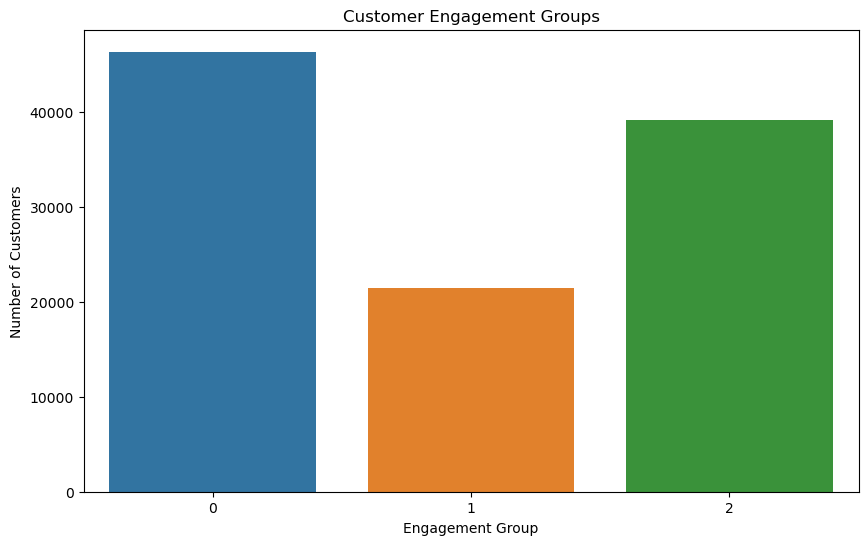

In [13]:
# plot the number of customers per engagement group
plt.figure(figsize=(10, 6))
sns.countplot(x='engagement_classification', data=user_engagement)
plt.title('Customer Engagement Groups')
plt.xlabel('Engagement Group')
plt.ylabel('Number of Customers')
plt.show()

In [14]:
# max,min, mean and total of engagemnt metric based on engagement classification
engage_class = user_engagement['engagement_classification'].unique().tolist()

for  i in engage_class:
    print(f"Engagement class: {i}")
    print(f"{engagement_stats(user_engagement[user_engagement['engagement_classification'] == i])} \n")

Engagement class: 2
                       Maximum     Minimum         Total       Average
Total Volume       578354950.0  33249009.0  1.134240e+13  2.900127e+08
number_of_session          2.0         1.0  3.912900e+04  1.000486e+00
Dur. (ms)             275587.0      7142.0  3.535883e+09  9.040866e+04 

Engagement class: 0
                        Maximum      Minimum         Total       Average
Total Volume       1.282632e+09  348704234.0  3.268158e+13  7.056522e+08
number_of_session  1.000000e+00          1.0  4.631400e+04  1.000000e+00
Dur. (ms)          2.756690e+05       7146.0  5.082198e+09  1.097335e+05 

Engagement class: 1
                        Maximum      Minimum         Total       Average
Total Volume       1.282700e+09  119768539.0  1.728411e+13  8.064253e+08
number_of_session  2.000000e+00          2.0  4.286600e+04  2.000000e+00
Dur. (ms)          2.756650e+05      18235.0  2.992389e+09  1.396160e+05 



- From the plot, there are more group 0 or less engaged users in the dataset than the other group.

- Class 0 users even though they are large in numbers they have larger total Total volume thus this user are engaged in the downloading or uploading activity more than the others. But the average duration they spent during sessions and average volume of DL/UL is lower than in Class 1.

- In contrast, Class 1 have the lowest number of user although these customers have larger total Volume, spend more time, and contain the most frequent users than Class 0.

- Class 0 customers have higher number than in Class 1 but they perfom less than the other two Class cutomers.

In [15]:
# top ten customer engaged per application
total_traffic['Customers'] = user_behavior['MSISDN/Number']
engaged_users_per_application(total_traffic)

The top ten customers of Social Media application
['33635211255.0', '33675792506.0', '33663767746.0', '33661102628.0', '33760164786.0', '33610482093.0', '33665748361.0', '33666910163.0', '33662232758.0', '33659023655.0'] 

The top ten customers of Youtube application
['33659733051.0', '33656813336.0', '33661814096.0', '33671484463.0', '33760153835.0', '33658899375.0', '33659558901.0', '33782323908.0', '33659269991.0', '33698684936.0'] 

The top ten customers of Netflix application
['33621136479.0', '33658127937.0', '33659742624.0', '33699287663.0', '33680783737.0', '33761144147.0', '33620148989.0', '33760713370.0', '33650395850.0', '33664525495.0'] 

The top ten customers of Google application
['33663750591.0', '33658267047.0', '33668999669.0', '33664466218.0', '33699344557.0', '33662107439.0', '33664849809.0', '33661041364.0', '33680159280.0', '33781096191.0'] 

The top ten customers of Email application
['33658285182.0', '33659753265.0', '33658200991.0', '33661687518.0', '33617412938

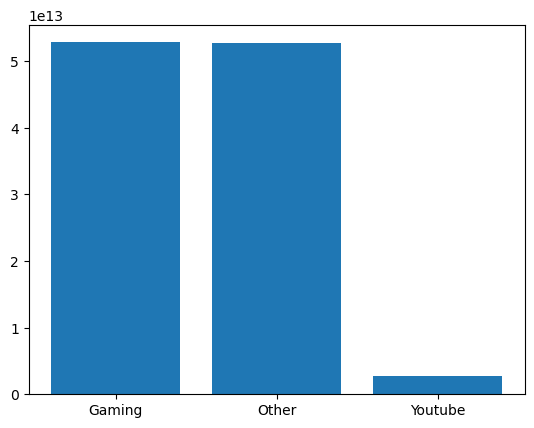

In [16]:
top_three_app = total_traffic[['Social Media','Youtube','Netflix','Google','Email','Gaming','Other']].sum().sort_values(ascending = False).head(3)
X = top_three_app.index.tolist()
y = top_three_app.values.tolist()
plt.bar(X, y)
plt.show()

In [17]:
top_three_app 

Gaming     5.281963e+13
Other      5.264434e+13
Youtube    2.775631e+12
dtype: float64

> Most of the customers are engaged in Gaming application and others(which aren't specified)

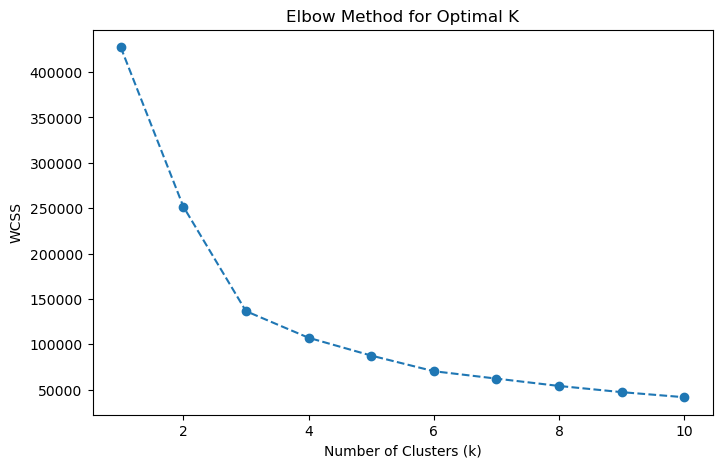

In [18]:
# k-means and k values for optimization
scaler = StandardScaler()
scaled_data = scaler.fit_transform(user_engagement.select_dtypes(np.number))

wcss = [] 

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)  # Inertia gives the WCSS for the k clusters
    
# Plot the Elbow graph
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.show()

- The optimal number of clusters (k) is where the decrease in WCSS (Within-Cluster Sum of Squares) starts to level off. From the plot, this point seems to be around 3 clusters, as the steep drop occurs between 1 and 3, after which the rate of decrease becomes more gradual.Therefore engagement of users being classified into 3 in the above implementation has given a good insight.


In [19]:
# export user engagement dataframe for task 4 analysis
user_engagement.to_csv('engagement.csv',index = False)  